In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import random
import time
import pickle
import gc
import re
import itertools

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
main_dir = '/tf/notebooks/'

In [4]:
descr_df = pd.read_csv(main_dir+'final-project/data/QA/full_descr.txt', sep="|", index_col=0)
descr_df.reset_index(inplace=True)
descr_df.shape

/usr/local/lib/python3.5/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(2914464, 17)

In [5]:
demo_df = pd.read_csv(main_dir+'final-project/data/QA/congresspeople_demo.txt', sep='|')
demo_df.shape

(1800, 14)

In [6]:
demo_df.head()

,Full Name,Last Name,First Name,First Last,List of Congresses,Chamber,State,Gender,Party,Ethnicity,BirthYear,Congress Name,Alternative name (Wikipedia),Congress ID
0,"ABDNOR, JAMES",ABDNOR,JAMES,JAMES ABDNOR,97 98 99,S,SD,M,R,ME,1923,"ABDNOR, JAMES",JAMES ABDNOR,A000009
1,"ABERCROMBIE, NEIL",ABERCROMBIE,NEIL,NEIL ABERCROMBIE,99 102 103 104 105 106 107 108 109 110 111,H,HI,M,D,W,1938,"ABERCROMBIE, NEIL",NEIL ABERCROMBIE,A000014
2,"ABRAHAM, RALPH",ABRAHAM,RALPH,RALPH ABRAHAM,114,H,LA,M,R,W,1954,"ABRAHAM, RALPH LEE",RALPH ABRAHAM,A000374
3,"ABRAHAM, SPENCER",ABRAHAM,SPENCER,SPENCER ABRAHAM,104 105 106,S,MI,M,R,ME,1952,"ABRAHAM, SPENCER",SPENCER ABRAHAM,A000355
4,"ACEVEDO-VILA, ANIBAL",ACEVEDO-VILA,ANIBAL,ANIBAL ACEVEDO-VILA,107 108,H,PR,M,A,H,1962,"ACEVEDO-VILA, ANIBAL",ANÍBAL ACEVEDO VILÁ,A000359


In [7]:
ldadata_path = main_dir+'final-project/LDA/data/'

In [8]:
all_speeches_topics_df = pd.read_pickle(ldadata_path+'speeches_topics_gender_36')
topic_names = pd.read_csv(os.path.join(ldadata_path, 'gender_topics.txt'), sep="|", header=None, names=["Topic_Num", "Topic_Name"])
all_speeches_topics_df = all_speeches_topics_df.merge(topic_names, left_on='Prim_Topic', right_on='Topic_Num')\
                                               .merge(topic_names, left_on='Sec_Topic', right_on='Topic_Num')\
                                               .drop(columns=['Topic_Num_x', 'Topic_Num_y'])\
                                               .rename(columns={'Topic_Name_x': 'Prim_Topic_Name', 'Topic_Name_y': 'Sec_Topic_Name'})
all_speeches_topics_df.Speech_id = all_speeches_topics_df.Speech_id.astype('int')
all_speeches_topics_df.head()

,Topic_Count,Prim_Topic,Prim_Topic_Contrib,Prim_Topic_Keywords,Sec_Topic,Sec_Topic_Contrib,Speech_id,Prim_Topic_Name,Sec_Topic_Name
0,2.0,8.0,0.76,"vote,judge,nomination,senators,district,record...",9.0,0.20,1080099024,Judicial Nominations,Common Phrases
1,2.0,8.0,0.69,"vote,judge,nomination,senators,district,record...",9.0,0.25,1080195295,Judicial Nominations,Common Phrases
2,4.0,8.0,0.41,"vote,judge,nomination,senators,district,record...",9.0,0.36,1110012936,Judicial Nominations,Common Phrases
3,9.0,8.0,0.53,"vote,judge,nomination,senators,district,record...",9.0,0.13,1060019143,Judicial Nominations,Common Phrases
4,4.0,8.0,0.54,"vote,judge,nomination,senators,district,record...",9.0,0.22,1130102128,Judicial Nominations,Common Phrases


In [9]:
classdata_path = main_dir+'final-project/Classification/data/gender'

In [10]:
descr_pred_df = pd.read_pickle(os.path.join(classdata_path, 'gender_preds.pkl'))
descr_pred_df.shape

(62716, 20)

In [11]:
descr_pred_df.head()

,speech_id,date,char_count,word_count,speakerid,Party,Congress,Chamber,State,Ethnicity,Age,Age_lt_med,NonWhite,Female,speaker,Full Name,match,ids,pred_probs_combo,pred_combo
0,1080099024,20031030,436,70,108118820.0,D,108,H,CA,W,66.0,0.0,0.0,1.0,Mrs. CAPPS,"CAPPS, LOIS",fuzzy,1080099024,0.562533,True
1,1080165561,20040625,6213,1056,108120190.0,D,108,H,CA,B,58.0,0.0,1.0,1.0,Ms. LEE,"LEE, BARBARA",fuzzy,1080165561,0.556122,True
2,1090156218,20060711,1230,198,109116060.0,D,109,H,CA,H,49.0,1.0,1.0,1.0,Ms. SOLIS,"SOLIS, HILDA",exact,1090156218,0.901894,True
3,1060121740,20000315,700,136,106117690.0,D,106,H,NY,W,56.0,0.0,0.0,1.0,Mrs. McCARTHY of New York,"MCCARTHY, CAROLYN",exact,1060121740,0.768826,True
4,1100177577,20080623,3302,490,110114720.0,R,110,H,VA,W,59.0,0.0,0.0,1.0,Mrs. DRAKE,"DRAKE, THELMA",exact,1100177577,0.500139,True


In [12]:
final_df = descr_pred_df.merge(all_speeches_topics_df, 
                               left_on='speech_id',
                               right_on='Speech_id')\
                        .drop(columns=['Speech_id'])
final_df.shape

(61957, 28)

In [13]:
final_df['Correct_pred'] = final_df.Female == final_df.pred_combo
np.mean(final_df['Correct_pred'])

0.7656923350065368

### Average gender score by topic

In [14]:
prim_topics_sorted = final_df[['pred_probs_combo', 'Correct_pred', 'Prim_Topic_Name']]\
                        .groupby('Prim_Topic_Name')\
                        .agg({'pred_probs_combo': ['count', 'mean'],
                              'Correct_pred': ['mean']})\
                        .sort_values(by=('pred_probs_combo','mean'), ascending=False)
prim_topics_sorted.columns = ['_'.join(col) for col in prim_topics_sorted.columns]
prim_topics_sorted.reset_index(inplace=True)
prim_topics_sorted

,Prim_Topic_Name,Correct_pred_mean,pred_probs_combo_count,pred_probs_combo_mean
0,Healthcare and Women's Health,0.780269,892,0.604094
1,Poverty and Welfare,0.821516,409,0.582440
2,Children's Diseases,0.769283,1478,0.576591
3,Economy,0.779835,1458,0.572771
4,Natural Disasters,0.762938,599,0.571748
5,Education,0.770635,1260,0.559866
6,Military,0.774590,732,0.556680
7,Crime and Immigration,0.764497,845,0.554956
8,Judicial Nominations,0.784504,826,0.550107
9,Great Nation,0.759709,2884,0.549181


In [15]:
sec_topics_sorted = final_df[['pred_probs_combo', 'Correct_pred', 'Sec_Topic_Name']]\
                        .groupby('Sec_Topic_Name')\
                        .agg({'pred_probs_combo': ['count', 'mean'],
                              'Correct_pred': ['mean']})\
                        .sort_values(by=('pred_probs_combo','mean'), ascending=False)
sec_topics_sorted.columns = ['_'.join(col) for col in sec_topics_sorted.columns]
sec_topics_sorted.reset_index(inplace=True)
sec_topics_sorted

,Sec_Topic_Name,Correct_pred_mean,pred_probs_combo_count,pred_probs_combo_mean
0,Poverty and Welfare,0.767584,654,0.577480
1,Healthcare and Women's Health,0.779550,1066,0.571693
2,Economy,0.768707,1617,0.564278
3,Education,0.771930,1140,0.557802
4,Children's Diseases,0.764170,988,0.553559
5,Natural Disasters,0.734584,746,0.549431
6,Great Nation,0.773694,3102,0.542651
7,The Navy,0.814516,372,0.542452
8,Positive Words,0.743628,2707,0.541653
9,Positive Words 2,0.764510,2705,0.538525


### Topics by Congress

In [16]:
congress_df = final_df[['Congress', 'Prim_Topic_Name', 'speech_id', 'Female', 'pred_probs_combo']]\
                .groupby(['Congress', 'Prim_Topic_Name'])\
                .agg({'speech_id': ['count'], 'Female': ['mean', 'sum'], 'pred_probs_combo': ['mean']})
congress_df.columns = ['_'.join(col) for col in congress_df.columns]
congress_df.reset_index(inplace=True)
congress_df.shape

(647, 6)

In [17]:
congress_df.head()

,Congress,Prim_Topic_Name,Female_mean,Female_sum,speech_id_count,pred_probs_combo_mean
0,97,Agriculture,0.235294,4.0,17,0.379829
1,97,Budgets and Spending,0.293750,47.0,160,0.479891
2,97,Children's Diseases,0.368421,7.0,19,0.457664
3,97,Common Congressional Phrases,0.112069,39.0,348,0.414317
4,97,Common Phrases,0.062241,15.0,241,0.406904


In [18]:
prim_topics_sorted.Prim_Topic_Name[:5]

0    Healthcare and Women's Health
1              Poverty and Welfare
2              Children's Diseases
3                          Economy
4                Natural Disasters
Name: Prim_Topic_Name, dtype: object

In [19]:
list(descr_df)

['speech_id',
 'date',
 'char_count',
 'word_count',
 'speakerid',
 'Party',
 'Congress',
 'Chamber',
 'State',
 'Ethnicity',
 'Age',
 'Age_lt_med',
 'NonWhite',
 'Female',
 'speaker',
 'Full Name',
 'match']

In [20]:
speaker_share_congress = descr_df[['Full Name', 'Party', 'State', 'Congress', 'Female']]\
                            .groupby(['Full Name', 'Party', 'State', 'Congress'])\
                            .mean()\
                            .reset_index()
speaker_share_congress = speaker_share_congress.groupby('Congress').Female.mean().reset_index()
speaker_share_congress.shape

(18, 2)

In [21]:
speaker_share_congress.head()

,Congress,Female
0,97,0.040367
1,98,0.044199
2,99,0.046125
3,100,0.047706
4,101,0.056569


In [22]:
speech_share_congress = descr_df[['Congress', 'Female']]\
                            .groupby(['Congress'])\
                            .mean()\
                            .reset_index()
speech_share_congress.shape

(18, 2)

In [23]:
speech_share_congress.head()

,Congress,Female
0,97,0.019812
1,98,0.022636
2,99,0.024895
3,100,0.025246
4,101,0.032856


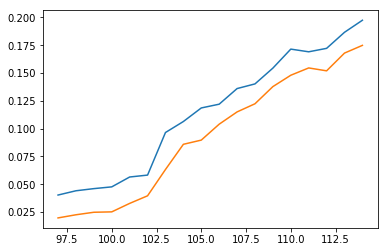

In [24]:
plt.plot(speaker_share_congress.Congress, speaker_share_congress.Female)
plt.plot(speech_share_congress.Congress, speech_share_congress.Female)

In [25]:
top_gender_topics = list(prim_topics_sorted.Prim_Topic_Name[:5])
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']

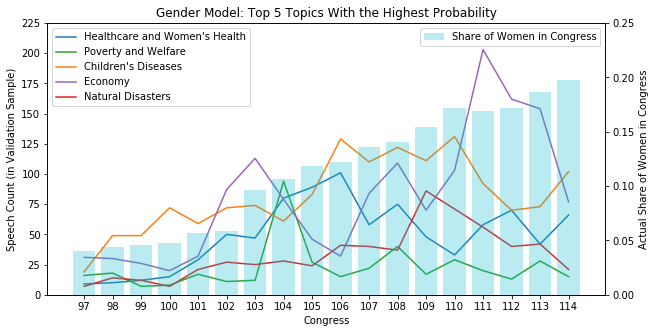

In [173]:
fig, ax1 = plt.subplots(figsize=(10,5))
plt.xlabel('Congress')
plt.ylabel('Speech Count (in Validation Sample)')
plt.title('Gender Model: Top 5 Topics With the Highest Probability')

for i in range(len(top_gender_topics)):
    x = congress_df[congress_df.Prim_Topic_Name==top_gender_topics[i]].Congress
    y = congress_df[congress_df.Prim_Topic_Name==top_gender_topics[i]].speech_id_count
    ax1.plot(x, y, color=colors[i], label=top_gender_topics[i])
    ax1.set_xticks(range(97,115))
    ax1.legend()
ax1.set_ylim(0, 225)
ax2 = ax1.twinx()
ax2.bar(speaker_share_congress.Congress, speaker_share_congress.Female, color='tab:cyan', alpha=0.3, label='Share of Women in Congress')
ax2.set_ylim(0, 0.25)
ax2.legend(loc='upper right')
ax2.set_ylabel('Actual Share of Women in Congress')
plt.show()

### Topics in Classification buckets

In [174]:
topic_share = final_df[['Prim_Topic_Name', 'speech_id']].groupby('Prim_Topic_Name').count() / final_df.shape[0]
topic_share.columns = ['topic_share']
topic_share.reset_index(inplace=True)
topic_share.head()

,Prim_Topic_Name,topic_share
0,Agriculture,0.003357
1,Budgets and Spending,0.038801
2,Children's Diseases,0.023855
3,Common Congressional Phrases,0.092387
4,Common Phrases,0.059896


In [175]:
cnt_by_pred = final_df[['Female', 'pred_combo', 'speech_id']].groupby(['Female', 'pred_combo']).count()
cnt_by_pred.columns = ['Speech_cnt_pred']
cnt_by_pred.reset_index(inplace=True)
cnt_by_pred['Bucket'] = ['TN', 'FP', 'FN', 'TP']
cnt_by_pred.shape

(4, 4)

In [99]:
final_df.shape

(61957, 30)

In [77]:
cnt_by_pred.head()

,Female,pred_combo,Speech_cnt_pred,Bucket
0,0.0,False,23045,TN
1,0.0,True,7891,FP
2,1.0,False,6626,FN
3,1.0,True,24395,TP


In [78]:
cnt_by_pred_topic = final_df[['Prim_Topic_Name', 'Female', 'pred_combo', 'speech_id']].groupby(['Female', 'pred_combo', 'Prim_Topic_Name']).count()
cnt_by_pred_topic.columns = ['Speech_cnt_pred_topic']
cnt_by_pred_topic.reset_index(inplace=True)
cnt_by_pred_topic = cnt_by_pred_topic.merge(cnt_by_pred, on=['Female', 'pred_combo'])
cnt_by_pred_topic['topic_pred_share'] = cnt_by_pred_topic.Speech_cnt_pred_topic / cnt_by_pred_topic.Speech_cnt_pred
cnt_by_pred_topic = cnt_by_pred_topic.merge(topic_share, on='Prim_Topic_Name')
cnt_by_pred_topic['topic_share_index'] = cnt_by_pred_topic.topic_pred_share / cnt_by_pred_topic.topic_share
cnt_by_pred_topic.shape

(144, 9)

In [79]:
cnt_by_pred_topic.head()

,Female,pred_combo,Prim_Topic_Name,Speech_cnt_pred_topic,Speech_cnt_pred,Bucket,topic_pred_share,topic_share,topic_share_index
0,0.0,False,Agriculture,87,23045,TN,0.003775,0.003357,1.124526
1,0.0,True,Agriculture,29,7891,FP,0.003675,0.003357,1.094695
2,1.0,False,Agriculture,20,6626,FN,0.003018,0.003357,0.899095
3,1.0,True,Agriculture,72,24395,TP,0.002951,0.003357,0.879141
4,0.0,False,Budgets and Spending,926,23045,TN,0.040182,0.038801,1.035596


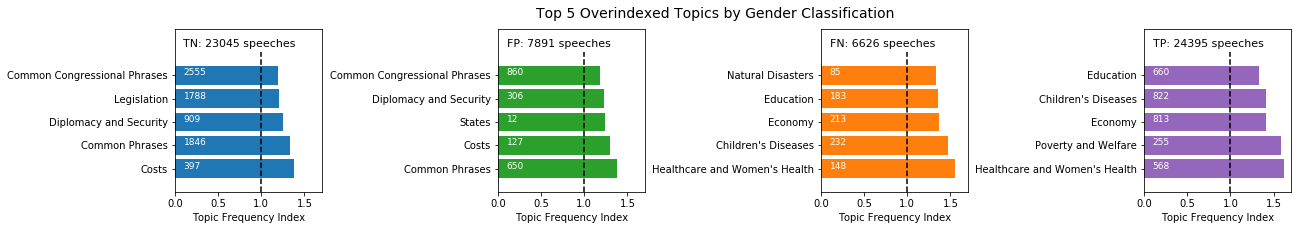

In [201]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 3))
fig.subplots_adjust(wspace=1.2)
# fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
fig.suptitle('Top 5 Overindexed Topics by Gender Classification', fontsize=14)
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']

for ax, b, i in zip(axes, cnt_by_pred.Bucket, range(4)):
    temp = cnt_by_pred_topic[cnt_by_pred_topic['Bucket']==b]
    temp = temp.sort_values(by='topic_share_index', ascending=False)
    temp = temp[['Prim_Topic_Name', 'topic_share_index','Speech_cnt_pred_topic']]
    temp = temp.head()
    speech_cnt = cnt_by_pred[cnt_by_pred.Bucket==b].Speech_cnt_pred.values[0]
    label = b+': '+str(speech_cnt)+' speeches'
    ax.text(0.1, 5.2, label, fontsize=11)
    ax.barh(temp.Prim_Topic_Name, temp.topic_share_index, align='center', color=colors[i])
    for i in range(5):
        ax.text(0.1, i, temp.Speech_cnt_pred_topic.values[i], fontsize=9, color='white')
    ax.vlines(x=1,ymin=-1,ymax=5, linestyles='dashed')
    ax.set_xlim(0,1.7)
    ax.set_ylim(-1,6)
    ax.set_xlabel('Topic Frequency Index')
plt.show()

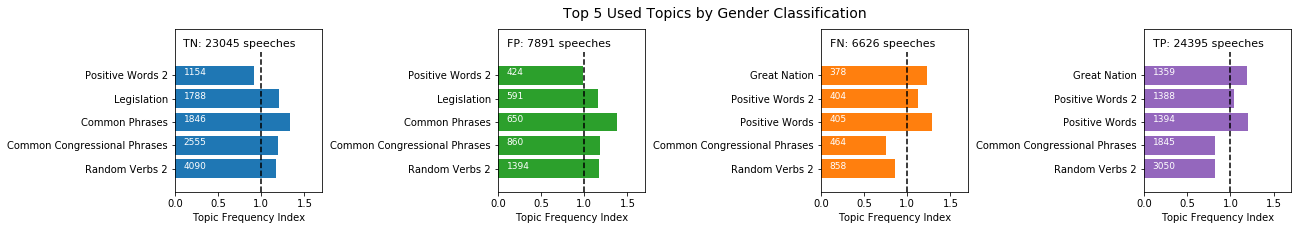

In [200]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 3))
fig.subplots_adjust(wspace=1.2)
# fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
fig.suptitle('Top 5 Used Topics by Gender Classification', fontsize=14)
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']

for ax, b, i in zip(axes, cnt_by_pred.Bucket, range(4)):
    temp = cnt_by_pred_topic[cnt_by_pred_topic['Bucket']==b]
    temp = temp.sort_values(by='Speech_cnt_pred_topic', ascending=False)
    temp = temp[['Prim_Topic_Name', 'topic_share_index','Speech_cnt_pred_topic']]
    temp = temp.head()
    speech_cnt = cnt_by_pred[cnt_by_pred.Bucket==b].Speech_cnt_pred.values[0]
    label = b+': '+str(speech_cnt)+' speeches'
    ax.text(0.1, 5.2, label, fontsize=11)
    ax.barh(temp.Prim_Topic_Name, temp.topic_share_index, align='center', color=colors[i])
    for i in range(5):
        ax.text(0.1, i, temp.Speech_cnt_pred_topic.values[i], fontsize=9, color='white')
    ax.vlines(x=1,ymin=-1,ymax=5, linestyles='dashed')
    ax.set_xlim(0,1.7)
    ax.set_ylim(-1,6)
    ax.set_xlabel('Topic Frequency Index')
plt.show()

### Topics in Misclassified speeches

In [105]:
misclass = final_df[((final_df.Female==0) & (final_df.pred_combo==1)) | ((final_df.Female==1) & (final_df.pred_combo==0))]
misclass.shape

(14517, 30)

In [107]:
bins = [0, 0.4, 0.5, 0.6, 1]
misclass['binned'] = np.digitize(misclass.pred_probs_combo, bins)
misclass['binned'].value_counts()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


4    4365
3    3526
1    3395
2    3231
Name: binned, dtype: int64

In [112]:
cnt_by_bin = misclass[['binned', 'speech_id']].groupby(['binned']).count().reset_index()
cnt_by_bin.columns = ['Bin', 'Speech_cnt_bin']
cnt_by_bin.head()

,Bin,Speech_cnt_bin
0,1,3395
1,2,3231
2,3,3526
3,4,4365


In [132]:
cnt_by_bin_topic = misclass[['Prim_Topic_Name', 'binned', 'Female', 'speech_id']]\
                            .groupby(['binned', 'Female', 'Prim_Topic_Name'])\
                            .count()\
                            .reset_index()\
                            .rename(columns={'speech_id': 'Speech_cnt_bin_topic', 'binned': 'Bin'}) \
                            .merge(cnt_by_bin, on='Bin')\
                            .merge(topic_share, on='Prim_Topic_Name')
cnt_by_bin_topic['topic_bin_share'] = cnt_by_bin_topic.Speech_cnt_bin_topic / cnt_by_bin_topic.Speech_cnt_bin
cnt_by_bin_topic['topic_share_index'] = cnt_by_bin_topic.topic_bin_share / cnt_by_bin_topic.topic_share
cnt_by_bin_topic.head()

,Bin,Female,Prim_Topic_Name,Speech_cnt_bin_topic,Speech_cnt_bin,topic_share,topic_bin_share,topic_share_index
0,1,1.0,Agriculture,8,3395,0.003357,0.002356,0.701903
1,2,1.0,Agriculture,12,3231,0.003357,0.003714,1.106296
2,3,0.0,Agriculture,11,3526,0.003357,0.003120,0.929260
3,4,0.0,Agriculture,18,4365,0.003357,0.004124,1.228331
4,1,1.0,Budgets and Spending,135,3395,0.038801,0.039764,1.024825


In [135]:
pd.crosstab(cnt_by_bin_topic.Bin, cnt_by_bin_topic.Female)

Female,0.0,1.0
Bin,,
1,0,36
2,0,36
3,36,0
4,36,0


In [133]:
cnt_by_bin_topic.shape

(144, 8)

In [134]:
cnt_by_bin_topic.Speech_cnt_bin_topic.sum()

14517

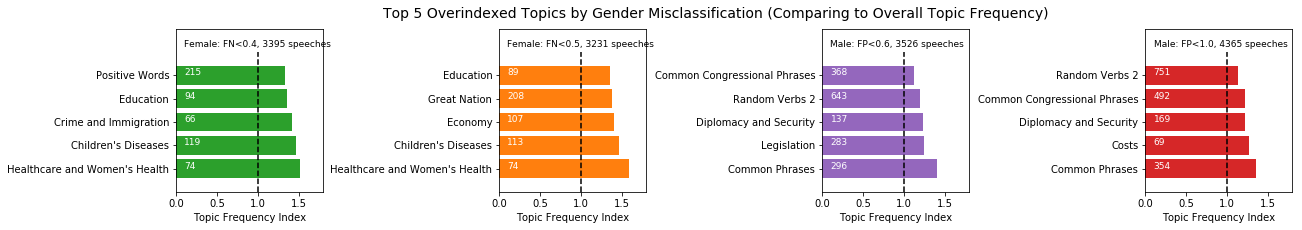

In [197]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 3))
fig.subplots_adjust(wspace=1.2)
# fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
fig.suptitle('Top 5 Overindexed Topics by Gender Misclassification (Comparing to Overall Topic Frequency)', fontsize=14)
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']
categories = ['Female: FN<0.4', 'Female: FN<0.5', 'Male: FP<0.6', 'Male: FP<1.0']

for ax, b, in zip(axes, range(1,5)):
    temp = cnt_by_bin_topic[cnt_by_bin_topic['Bin']==b]
    speech_cnt = temp.Speech_cnt_bin_topic.sum()
    temp = temp[temp.Speech_cnt_bin_topic>cnt_by_bin_topic_correct.Speech_cnt_bin_topic.median()]
    temp = temp.sort_values(by='topic_share_index', ascending=False)
    temp = temp[['Prim_Topic_Name', 'topic_share_index','Speech_cnt_bin_topic']]
    temp = temp.head()
    label = str(categories[b-1])+', '+str(speech_cnt)+' speeches'
    ax.text(0.1, 5.2, label, fontsize=9)
    ax.barh(temp.Prim_Topic_Name, temp.topic_share_index, align='center', color=colors[b])
    for i in range(5):
        ax.text(0.1, i, temp.Speech_cnt_bin_topic.values[i], fontsize=9, color='white')
    ax.vlines(x=1,ymin=-1,ymax=5, linestyles='dashed')
    ax.set_xlim(0,1.8)
    ax.set_ylim(-1,6)
    ax.set_xlabel('Topic Frequency Index')
plt.show()

In [136]:
correctclass = final_df[((final_df.Female==1) & (final_df.pred_combo==1)) | ((final_df.Female==0) & (final_df.pred_combo==0))]
correctclass.shape

(47440, 30)

In [137]:
correctclass.shape[0]+misclass.shape[0]-final_df.shape[0]

0

In [187]:
correct_topic_cnt = correctclass[['Female', 'speech_id']]\
                            .groupby('Female')\
                            .count()\
                            .reset_index()\
                            .rename(columns={'speech_id': 'gender_cnt'})
correct_topic_share = correctclass[['Prim_Topic_Name', 'Female', 'speech_id']]\
                            .groupby(['Prim_Topic_Name', 'Female'])\
                            .count()\
                            .reset_index()\
                            .rename(columns={'speech_id': 'gender_topic_cnt'})\
                            .merge(correct_topic_cnt, on='Female')
correct_topic_share['correct_topic_share'] = correct_topic_share.gender_topic_cnt / correct_topic_share.gender_cnt
correct_topic_share.head()

,Prim_Topic_Name,Female,gender_topic_cnt,gender_cnt,correct_topic_share
0,Agriculture,0.0,87,23045,0.003775
1,Budgets and Spending,0.0,926,23045,0.040182
2,Children's Diseases,0.0,315,23045,0.013669
3,Common Congressional Phrases,0.0,2555,23045,0.110870
4,Common Phrases,0.0,1846,23045,0.080104


In [188]:
cnt_by_bin_topic_correct = cnt_by_bin_topic.merge(correct_topic_share, on=['Prim_Topic_Name', 'Female'])
cnt_by_bin_topic_correct['correct_topic_share_index'] = cnt_by_bin_topic_correct.topic_bin_share / cnt_by_bin_topic_correct.correct_topic_share
cnt_by_bin_topic_correct.head()

,Bin,Female,Prim_Topic_Name,Speech_cnt_bin_topic,Speech_cnt_bin,topic_share,topic_bin_share,topic_share_index,gender_topic_cnt,gender_cnt,correct_topic_share,correct_topic_share_index
0,1,1.0,Agriculture,8,3395,0.003357,0.002356,0.701903,72,24395,0.002951,0.798396
1,2,1.0,Agriculture,12,3231,0.003357,0.003714,1.106296,72,24395,0.002951,1.258382
2,3,0.0,Agriculture,11,3526,0.003357,0.003120,0.929260,87,23045,0.003775,0.826357
3,4,0.0,Agriculture,18,4365,0.003357,0.004124,1.228331,87,23045,0.003775,1.092310
4,1,1.0,Budgets and Spending,135,3395,0.038801,0.039764,1.024825,910,24395,0.037303,1.065991


In [153]:
temp.Speech_cnt_bin_topic.values

array([ 24,  66, 221, 215,  39])

In [191]:
cnt_by_bin_topic_correct.Speech_cnt_bin_topic.median()

59.5

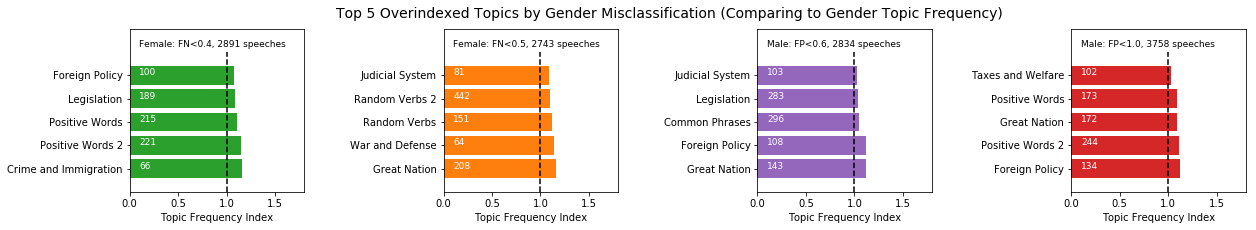

In [193]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 3))
fig.subplots_adjust(wspace=0.8)
# fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
fig.suptitle('Top 5 Overindexed Topics by Gender Misclassification (Comparing to Gender Topic Frequency)', fontsize=14)
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']
categories = ['Female: FN<0.4', 'Female: FN<0.5', 'Male: FP<0.6', 'Male: FP<1.0']

for ax, b, in zip(axes, range(1,5)):
    temp = cnt_by_bin_topic_correct[cnt_by_bin_topic_correct['Bin']==b]
    speech_cnt = temp.Speech_cnt_bin_topic.sum()
    temp = temp[temp.Speech_cnt_bin_topic>cnt_by_bin_topic_correct.Speech_cnt_bin_topic.median()]
    temp = temp.sort_values(by='correct_topic_share_index', ascending=False)
    temp = temp[['Prim_Topic_Name', 'correct_topic_share_index','Speech_cnt_bin_topic']]
    temp = temp.head()
    label = str(categories[b-1])+', '+str(speech_cnt)+' speeches'
    ax.text(0.1, 5.2, label, fontsize=9)
    for i in range(5):
        ax.text(0.1, i, temp.Speech_cnt_bin_topic.values[i], fontsize=9, color='white')
    ax.barh(temp.Prim_Topic_Name, temp.correct_topic_share_index, align='center', color=colors[b])
    ax.vlines(x=1,ymin=-1,ymax=5, linestyles='dashed')
    ax.set_xlim(0,1.8)
    ax.set_ylim(-1,6)
    ax.set_xlabel('Topic Frequency Index')
plt.show()

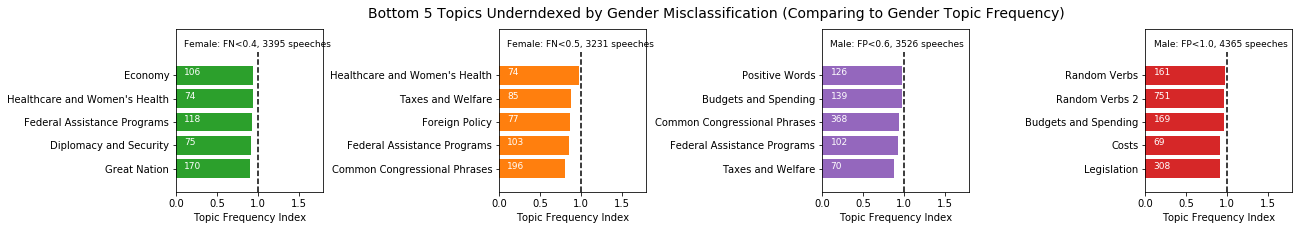

In [198]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 3))
fig.subplots_adjust(wspace=1.2)
# fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
fig.suptitle('Bottom 5 Topics Underndexed by Gender Misclassification (Comparing to Gender Topic Frequency)', fontsize=14)
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']
categories = ['Female: FN<0.4', 'Female: FN<0.5', 'Male: FP<0.6', 'Male: FP<1.0']

for ax, b, in zip(axes, range(1,5)):
    temp = cnt_by_bin_topic_correct[cnt_by_bin_topic_correct['Bin']==b]
    speech_cnt = temp.Speech_cnt_bin_topic.sum()
    temp = temp[temp.Speech_cnt_bin_topic>cnt_by_bin_topic_correct.Speech_cnt_bin_topic.median()]
    temp = temp.sort_values(by='correct_topic_share_index', ascending=True)
    temp = temp[['Prim_Topic_Name', 'correct_topic_share_index','Speech_cnt_bin_topic']]
    temp = temp.head()
    label = str(categories[b-1])+', '+str(speech_cnt)+' speeches'
    ax.text(0.1, 5.2, label, fontsize=9)
    for i in range(5):
        ax.text(0.1, i, temp.Speech_cnt_bin_topic.values[i], fontsize=9, color='white')
    ax.barh(temp.Prim_Topic_Name, temp.correct_topic_share_index, align='center', color=colors[b])
    ax.vlines(x=1,ymin=-1,ymax=5, linestyles='dashed')
    ax.set_xlim(0,1.8)
    ax.set_ylim(-1,6)
    ax.set_xlabel('Topic Frequency Index')
plt.show()

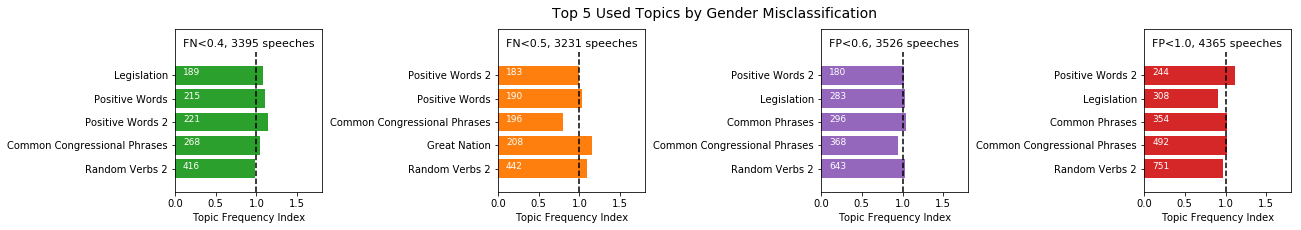

In [171]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 3))
fig.subplots_adjust(wspace=1.2)
# fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
fig.suptitle('Top 5 Used Topics by Gender Misclassification', fontsize=14)
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']
categories = ['FN<0.4', 'FN<0.5', 'FP<0.6', 'FP<1.0']

for ax, b, in zip(axes, range(1,5)):
    temp = cnt_by_bin_topic_correct[cnt_by_bin_topic_correct['Bin']==b]
    speech_cnt = temp.Speech_cnt_bin_topic.sum()
    temp = temp.sort_values(by='Speech_cnt_bin_topic', ascending=False)
    temp = temp[['Prim_Topic_Name', 'correct_topic_share_index','Speech_cnt_bin_topic']]
    temp = temp.head()
    label = str(categories[b-1])+', '+str(speech_cnt)+' speeches'
    ax.text(0.1, 5.2, label, fontsize=11)
    for i in range(5):
        ax.text(0.1, i, temp.Speech_cnt_bin_topic.values[i], fontsize=9, color='white')
    ax.barh(temp.Prim_Topic_Name, temp.correct_topic_share_index, align='center', color=colors[b])
    ax.vlines(x=1,ymin=-1,ymax=5, linestyles='dashed')
    ax.set_xlim(0,1.8)
    ax.set_ylim(-1,6)
    ax.set_xlabel('Topic Frequency Index')
plt.show()